In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from kaggle_secrets import UserSecretsClient
from glob import glob
from tqdm.notebook import tqdm
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers as L
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

%matplotlib inline

2023-02-01 07:41:27.989805: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-01 07:41:27.989987: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)
GCS_DS_PATH = KaggleDatasets().get_gcs_path('website-defacement')

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
N_JOBS = cpu_count()

IMG_SIZE = 224
EPOCHS = 20

print('N_JOBS:', N_JOBS)
print('Batch size:', BATCH_SIZE)
print('GCS_DS_PATH:', GCS_DS_PATH)

Running on TPU: grpc://10.0.0.2:8470


2023-02-01 07:41:33.629787: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-01 07:41:33.632145: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-01 07:41:33.632180: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-01 07:41:33.632211: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (392be95fcf2f): /proc/driver/nvidia/version does not exist
2023-02-01 07:41:33.635447: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

N_JOBS: 4
Batch size: 64
GCS_DS_PATH: gs://kds-0216339375dff4a7db6d61f7800f92202e600e6c4067e2d30681bc6c


In [3]:
dataset_path = '../input/website-defacement/'
img_paths = glob(dataset_path + 'image/*/*')
txt_paths = glob(dataset_path + 'text/*/*')
img_names = [path.split('/')[-1][:-4] for path in img_paths]
txt_names = [path.split('/')[-1][:-4] for path in txt_paths]
names = list(set(img_names).intersection(txt_names))

In [4]:
def prepare_data(name):
    if glob(dataset_path + f'text/defaced/{name}.txt'):
        path = dataset_path + f'text/defaced/{name}.txt'
        label = 1
    else:
        path = dataset_path + f'text/benign/{name}.txt'
        label = 0
    return (path, label)

output = Parallel(n_jobs=N_JOBS)(delayed(prepare_data)(name) for name in tqdm(names))
X, y = zip(*output)

X_train_txt, X_test_txt, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=2)
y_test = np.array(y_test)

X_train_txt, X_valid_txt, y_train, y_valid = train_test_split(X_train_txt, y_train, test_size=0.25, 
                                                      random_state=42)

  0%|          | 0/96234 [00:00<?, ?it/s]

In [5]:
vec = TfidfVectorizer(input='filename', max_features=1280)
X_train_txt = vec.fit_transform(X_train_txt)
X_test_txt = vec.transform(X_test_txt)
X_valid_txt = vec.transform(X_valid_txt)

In [6]:
def prepare_data(name):
    if glob(dataset_path + f'image/defaced/{name}.png'):
        return (f'{GCS_DS_PATH}/image/defaced/{name}.png', 1)
    else:
        return (f'{GCS_DS_PATH}/image/benign/{name}.png', 0)

output = Parallel(n_jobs=N_JOBS)(delayed(prepare_data)(name) for name in tqdm(names))
X, y = zip(*output)

X_train_img, X_test_img, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_ = to_categorical(y_train_, num_classes=2)
X_train_img, X_valid_img, y_train_, y_valid_ = train_test_split(X_train_img, y_train_, test_size=0.25, 
                                                      random_state=42)
print((y_train == y_train_).all(), (y_valid == y_valid_).all(), (y_test == y_test_).all())

  0%|          | 0/96234 [00:00<?, ?it/s]

True True True


In [7]:
def load_data(image_path, text, label=None):
    bits = tf.io.read_file(image_path)
    image = tf.image.decode_png(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    data = (image, text)
    
    if label is None:
        return image, text
    else:
        return data, label

train_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_train_img, X_train_txt.A, y_train))
    .shuffle(100000)
    .map(load_data, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_test_img, X_test_txt.A, y_test))
    .map(load_data, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

valid_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_valid_img, X_valid_txt.A, y_valid))
    .map(load_data, num_parallel_calls=AUTO)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

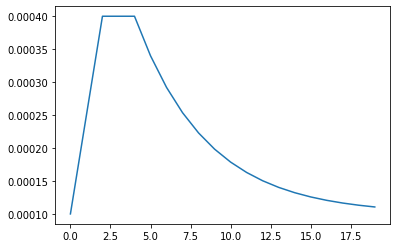

In [8]:
def lrfn(epoch=EPOCHS,
         lr_start=1e-4,
         lr_max=5e-5 * 8, 
         lr_min=1e-4,
         lr_rampup_epochs=2,
         lr_sustain_epochs=2,
         lr_exp_decay=0.8):
    if epoch < lr_rampup_epochs:
        lr = (lr_max-lr_start)/lr_rampup_epochs*epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max-lr_min)*lr_exp_decay**(epoch-lr_rampup_epochs-lr_sustain_epochs) + lr_min
    return lr

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

y = [lrfn(x) for x in range(EPOCHS)]
plt.plot(y)

### ViT Early Fusion

353255424/353253686 [==============================] - 4s 0us/step


/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


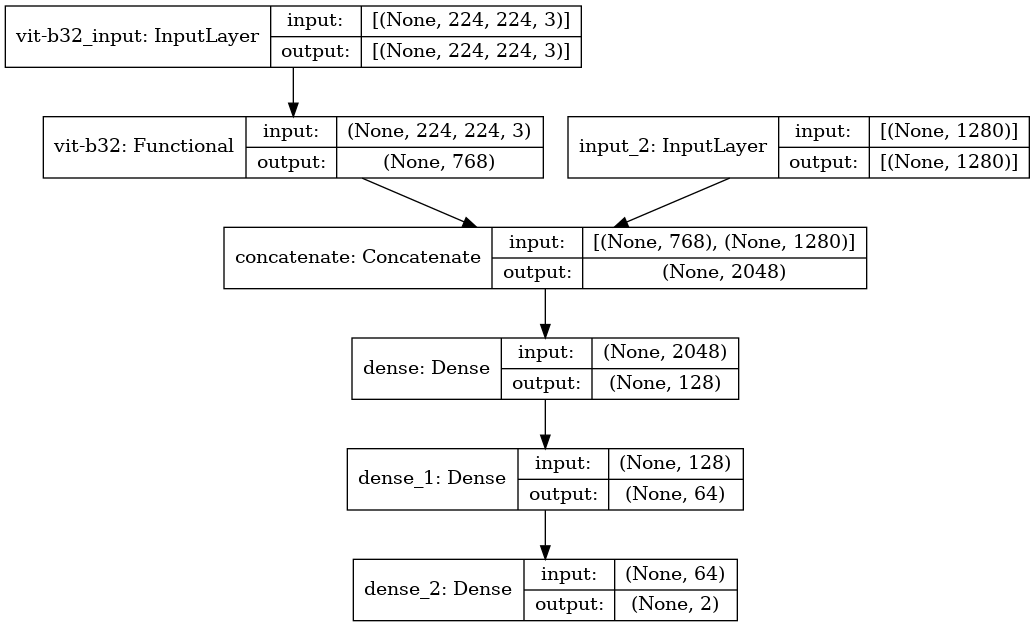

In [9]:
!pip install --quiet vit-keras

from vit_keras import vit

with strategy.scope():
    net = vit.vit_b32(
        image_size = (IMG_SIZE, IMG_SIZE),
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False
    )
    net.trainable = False

    image_model = Sequential()
    image_model.add(net)
    
    text_model = Sequential()
    text_model.add(L.Input(shape=(1280,)))
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [10]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('vit_weights.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                 callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20
902/902 - 2766s - loss: 0.1851 - accuracy: 0.9229 - val_loss: 0.1423 - val_accuracy: 0.9432
Epoch 2/20
902/902 - 22s - loss: 0.1071 - accuracy: 0.9574 - val_loss: 0.1025 - val_accuracy: 0.9580
Epoch 3/20
902/902 - 21s - loss: 0.0880 - accuracy: 0.9648 - val_loss: 0.1106 - val_accuracy: 0.9590
Epoch 4/20
902/902 - 21s - loss: 0.0846 - accuracy: 0.9655 - val_loss: 0.0966 - val_accuracy: 0.9642
Epoch 5/20
902/902 - 21s - loss: 0.0797 - accuracy: 0.9677 - val_loss: 0.0928 - val_accuracy: 0.9654
Epoch 6/20
902/902 - 21s - loss: 0.0735 - accuracy: 0.9700 - val_loss: 0.0861 - val_accuracy: 0.9680
Epoch 7/20
902/902 - 21s - loss: 0.0692 - accuracy: 0.9719 - val_loss: 0.0765 - val_accuracy: 0.9705
Epoch 8/20
902/902 - 21s - loss: 0.0663 - accuracy: 0.9729 - val_loss: 0.0732 - val_accuracy: 0.9726
Epoch 9/20
902/902 - 21s - loss: 0.0631 - accuracy: 0.9740 - val_loss: 0.0785 - val_accuracy: 0.9707
Epoch 10/20
902/902 - 21s - loss: 0.0592 - accuracy: 0.9763 - val_loss: 0.0799 - val_accu

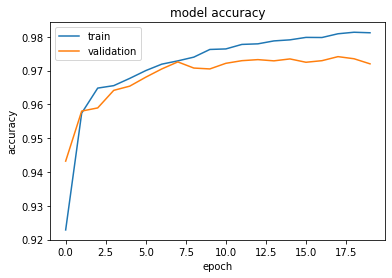

In [11]:
plot_hist(hist)

In [12]:
with strategy.scope():
    model.load_weights('vit_weights.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
print(metrics.classification_report(y_test, y_pred, digits=4))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({
                'TPR': '%.4f' % TPR,
                'FPR': '%.4f' % FPR,
                'ROC AUC': '%.4f' % auc,
            }, index=[0]).to_string(col_space=9, index=False)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 627s 2s/step
              precision    recall  f1-score   support

           0     0.9677    0.9852    0.9764     11415
           1     0.9778    0.9521    0.9648      7832

    accuracy                         0.9717     19247
   macro avg     0.9728    0.9687    0.9706     19247
weighted avg     0.9718    0.9717    0.9717     19247

[[11246   169]
 [  375  7457]]
      TPR       FPR   ROC AUC
   0.9521    0.0148    0.9969


### VGG19

80142336/80134624 [==============================] - 0s 0us/step


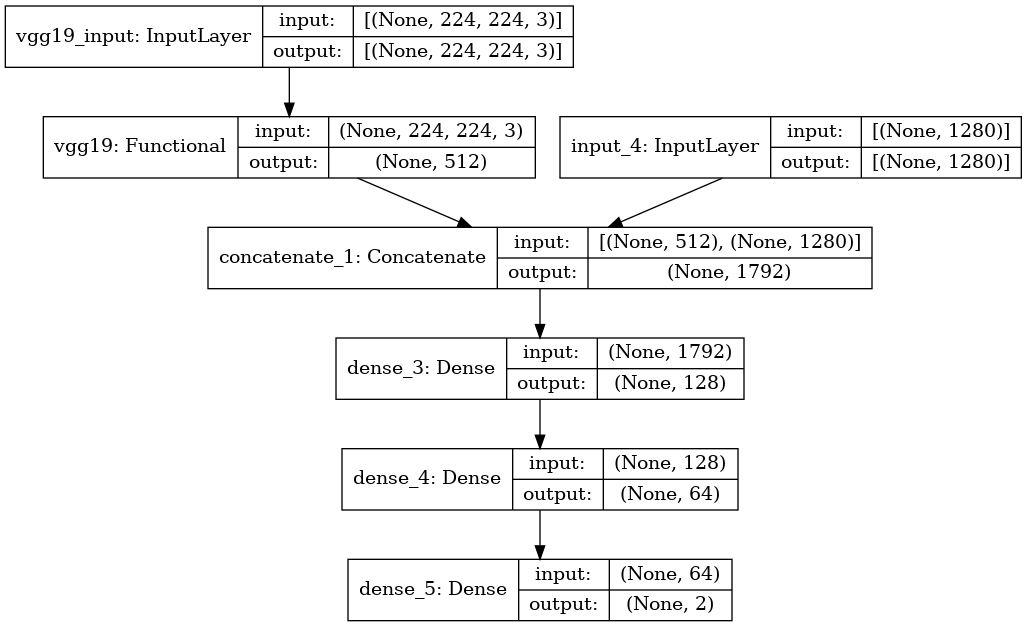

In [13]:
from tensorflow.keras.applications import VGG19
with strategy.scope():
    net = VGG19(
        include_top=False, 
        weights='imagenet', 
        pooling='avg', 
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    net.trainable = False

    image_model = Sequential()
    image_model.add(net)
    
    text_model = Sequential()
    text_model.add(L.Input(shape=(1280,)))
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [14]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('vgg19_weights.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                 callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20
902/902 - 46s - loss: 0.1372 - accuracy: 0.9465 - val_loss: 0.0842 - val_accuracy: 0.9668
Epoch 2/20
902/902 - 27s - loss: 0.0840 - accuracy: 0.9663 - val_loss: 0.1027 - val_accuracy: 0.9632
Epoch 3/20
902/902 - 27s - loss: 0.0720 - accuracy: 0.9711 - val_loss: 0.1050 - val_accuracy: 0.9639
Epoch 4/20
902/902 - 27s - loss: 0.0675 - accuracy: 0.9730 - val_loss: 0.0973 - val_accuracy: 0.9661
Epoch 5/20
902/902 - 27s - loss: 0.0632 - accuracy: 0.9747 - val_loss: 0.0953 - val_accuracy: 0.9670
Epoch 6/20
902/902 - 27s - loss: 0.0582 - accuracy: 0.9770 - val_loss: 0.0940 - val_accuracy: 0.9677
Epoch 7/20
902/902 - 27s - loss: 0.0539 - accuracy: 0.9787 - val_loss: 0.0928 - val_accuracy: 0.9686
Epoch 8/20
902/902 - 27s - loss: 0.0504 - accuracy: 0.9799 - val_loss: 0.0914 - val_accuracy: 0.9695
Epoch 9/20
902/902 - 27s - loss: 0.0473 - accuracy: 0.9815 - val_loss: 0.0909 - val_accuracy: 0.9700
Epoch 10/20
902/902 - 27s - loss: 0.0447 - accuracy: 0.9825 - val_loss: 0.0898 - val_accura

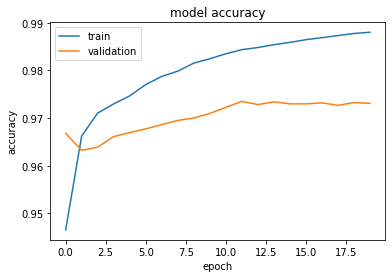

In [15]:
plot_hist(hist)

In [16]:
with strategy.scope():
    model.load_weights('vgg19_weights.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
print(metrics.classification_report(y_test, y_pred, digits=4))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({
                'TPR': '%.4f' % TPR,
                'FPR': '%.4f' % FPR,
                'ROC AUC': '%.4f' % auc,
            }, index=[0]).to_string(col_space=9, index=False)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 514s 2s/step
              precision    recall  f1-score   support

           0     0.9712    0.9848    0.9779     11415
           1     0.9773    0.9575    0.9673      7832

    accuracy                         0.9737     19247
   macro avg     0.9743    0.9711    0.9726     19247
weighted avg     0.9737    0.9737    0.9736     19247

[[11241   174]
 [  333  7499]]
      TPR       FPR   ROC AUC
   0.9575    0.0152    0.9968


### DenseNet169

51879936/51877672 [==============================] - 0s 0us/step


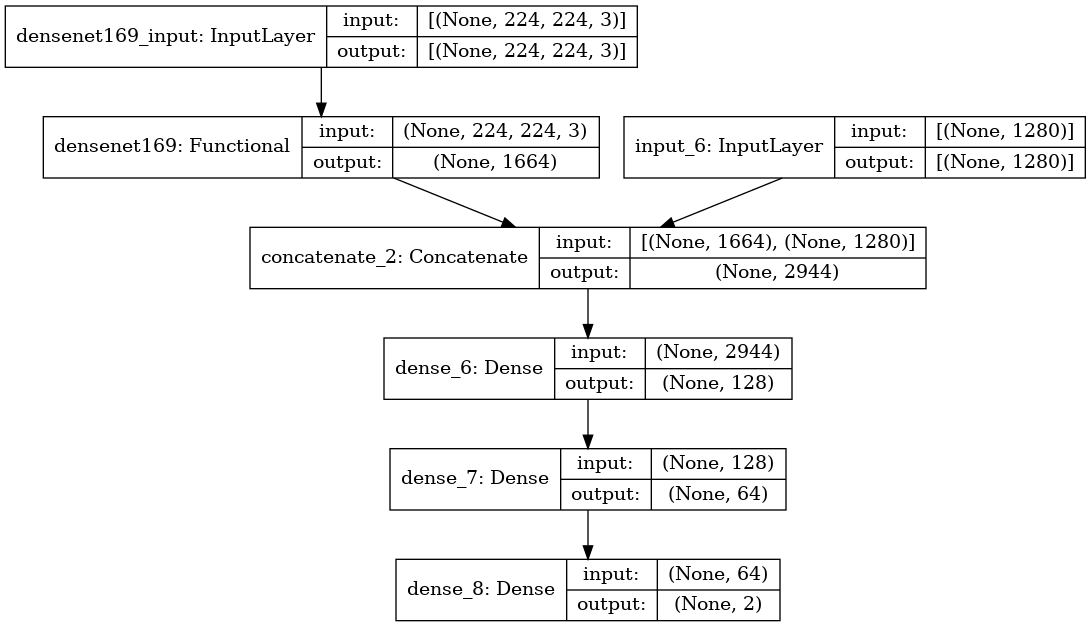

In [17]:
from tensorflow.keras.applications import DenseNet169
with strategy.scope():
    net = DenseNet169(
        include_top=False, 
        weights='imagenet', 
        pooling='avg', 
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    net.trainable = False

    image_model = Sequential()
    image_model.add(net)
    
    text_model = Sequential()
    text_model.add(L.Input(shape=(1280,)))
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [18]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('densenet_weights.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                 callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20
902/902 - 92s - loss: 0.1589 - accuracy: 0.9360 - val_loss: 0.0965 - val_accuracy: 0.9620
Epoch 2/20
902/902 - 40s - loss: 0.0904 - accuracy: 0.9639 - val_loss: 0.1005 - val_accuracy: 0.9617
Epoch 3/20
902/902 - 39s - loss: 0.0743 - accuracy: 0.9702 - val_loss: 0.1037 - val_accuracy: 0.9624
Epoch 4/20
902/902 - 40s - loss: 0.0670 - accuracy: 0.9727 - val_loss: 0.0929 - val_accuracy: 0.9665
Epoch 5/20
902/902 - 39s - loss: 0.0611 - accuracy: 0.9752 - val_loss: 0.0851 - val_accuracy: 0.9693
Epoch 6/20
902/902 - 39s - loss: 0.0561 - accuracy: 0.9775 - val_loss: 0.0811 - val_accuracy: 0.9711
Epoch 7/20
902/902 - 41s - loss: 0.0509 - accuracy: 0.9799 - val_loss: 0.0803 - val_accuracy: 0.9720
Epoch 8/20
902/902 - 39s - loss: 0.0468 - accuracy: 0.9819 - val_loss: 0.0804 - val_accuracy: 0.9725
Epoch 9/20
902/902 - 40s - loss: 0.0430 - accuracy: 0.9830 - val_loss: 0.0803 - val_accuracy: 0.9720
Epoch 10/20
902/902 - 38s - loss: 0.0395 - accuracy: 0.9846 - val_loss: 0.0825 - val_accura

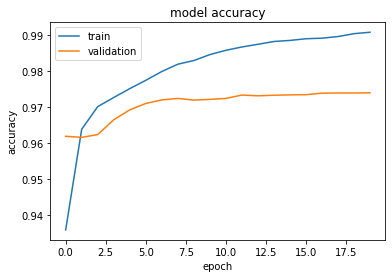

In [19]:
plot_hist(hist)

In [20]:
with strategy.scope():
    model.load_weights('densenet_weights.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
print(metrics.classification_report(y_test, y_pred, digits=4))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({
                'TPR': '%.4f' % TPR,
                'FPR': '%.4f' % FPR,
                'ROC AUC': '%.4f' % auc,
            }, index=[0]).to_string(col_space=9, index=False)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 516s 2s/step
              precision    recall  f1-score   support

           0     0.9650    0.9886    0.9767     11415
           1     0.9828    0.9478    0.9650      7832

    accuracy                         0.9720     19247
   macro avg     0.9739    0.9682    0.9708     19247
weighted avg     0.9723    0.9720    0.9719     19247

[[11285   130]
 [  409  7423]]
      TPR       FPR   ROC AUC
   0.9478    0.0114    0.9965
